In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [3]:
base_csv = '/Volumes/Cisco/Fall2021/onnx-exchange/Training/IMDB Dataset.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


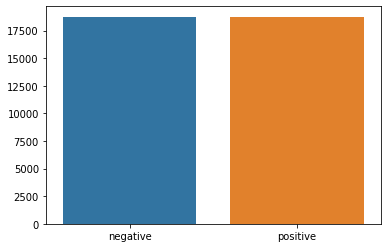

In [5]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [6]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s
import nltk
nltk.download('stopwords')
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mosesopenja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Length of vocabulary is 1000


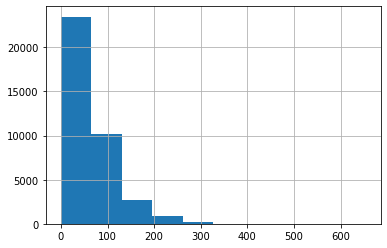

count    37500.000000
mean        69.189867
std         48.031120
min          0.000000
25%         39.000000
50%         54.000000
75%         84.000000
max        653.000000
dtype: float64

In [8]:
print(f'Length of vocabulary is {len(vocab)}')
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [9]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [10]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 84

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [11]:
import time
import os
import copy
import csv
import pandas as pd
from datetime import datetime

date = datetime.today().strftime('%Y-%m-%d')

In [15]:
class LSTMRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        #super(SentimentRNN,self).__init__()
        super().__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [16]:
training_round = 10
training_id = training_round
model_short_name = 'lstm'
framework = 'pytorch'

In [17]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256

model = LSTMRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)
path = '/Volumes/Cisco/Fall2021/onnx-exchange/Training/{}/{}/'.format(framework, model_short_name)
since_0 = time.time()
model_name = 'torch_state_lstm-imdb_2021-11-03_{}'.format(training_id)
model.load_state_dict(torch.load(path+model_name+'.pb', map_location=torch.device('cpu')))
t_elapsed_0 = time.time() - since_0

size0 = os.path.getsize(path+model_name+'.pb')
size0

#moving to gpu
model.to(device)


LSTMRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [18]:
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [19]:
def validate(model, data):
    
    val_h = model.init_hidden(batch_size)
    val_h = tuple([each.data for each in val_h])
    #inputs, labels = x.to(device), labels.to(device)

    #output, val_h = model(x, val_h)
    h0 = torch.zeros((no_layers,batch_size,hidden_dim)).to(device)
    c0 = torch.zeros((no_layers,batch_size,hidden_dim)).to(device)
    hidden = (h0,c0)
    total = 0
    correct = 0
    val_acc = 0.0
    since = time.time()
    for i, (images, labels) in enumerate(data):
        #images = images.cuda()
        print(i)
        
    
        x, (hn, cn) = model(images, (h0, c0))
        #x = model(images)
        accuracy = acc(x,labels)
        val_acc += accuracy
        
        #value, pred = torch.max(x,0)
        #pred = pred.data.cpu()
        total += x.size(0)
        #correct += torch.sum(pred == labels)
        if i == 147:
            break
    time_elapsed = time.time() - since
    print('accuracy: {}%'.format(val_acc*100./total),'time {:.0f}m {:.0f}s, {}'.format(time_elapsed // 60, time_elapsed % 60, time_elapsed) )
    #return correct*100./total

In [60]:
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
validate(model, valid_loader)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
accuracy: 56.37065637065637% time 8m 38s, 518.4412131309509


In [20]:
class GRURNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5, batch_size=100):
        #super(SentimentRNN,self).__init__()
        super().__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.gru = nn.GRU(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        gru_out, hidden = self.gru(embeds, hidden)
        
        gru_out = gru_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(gru_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.no_layers,batch_size,self.hidden_dim).zero_().to(device)
        return hidden
        
    #def init_hidden(self, batch_size):
    #    ''' Initializes hidden state '''
    #    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    #    # initialized to zero, for hidden state and cell state of LSTM
    #    h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    #    c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    #    hidden = (h0,c0)
    #    return hidden

In [21]:
model_short_name='gru'
model = GRURNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5, batch_size=batch_size)
path = '/Volumes/Cisco/Summer2022/onnx-exchange/Train2/{}/{}/'.format(framework, model_short_name)
since_0 = time.time()
model_name = 'torch_state_GRU-IMDb_2022-03-11_{}'.format(training_id)
model.load_state_dict(torch.load(path+model_name+'.pb', map_location=torch.device('cpu')))
t_elapsed_0 = time.time() - since_0

size0 = os.path.getsize(path+model_name+'.pb')
size0

#moving to gpu
model.to(device)

print(model)

GRURNN(
  (embedding): Embedding(1001, 64)
  (gru): GRU(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [23]:
# function to predict accuracy
import numpy as np

def validate(model, data):
    
    val_h = model.init_hidden(batch_size)
    val_h = val_h.data #tuple([each.data for each in val_h])
    #inputs, labels = x.to(device), labels.to(device)

    #h0 = torch.zeros((no_layers,batch_size,hidden_dim)).to(device)
    #c0 = torch.zeros((no_layers,batch_size,hidden_dim)).to(device)
    weight = next(model.parameters()).data
    hidden = weight.new(no_layers,batch_size,hidden_dim).zero_().to(device)
    
    total = 0
    correct = 0
    
    val_acc = 0.0
    list_time = []
    for i, (images, labels) in enumerate(data):
        since = time.time()
        #images = images.cuda()
        print(i)
        
    
        output, (hn, cn) = model(images, hidden)
        #x = model(images)
        # calculating accuracy
        accuracy = acc(output,labels)
        val_acc += accuracy
        
        #value, pred = torch.max(x,1)
        #pred = pred.data.cpu()
        total += output.size(0)
        #correct += torch.sum(pred == labels)
        time_elapsed = time.time() - since
        list_time.append(time_elapsed)
        
        if i == 147:
            break
    print(np.mean(time_elapsed))
    epoch_val_acc = val_acc/len(data.dataset)
    
    epoch_val_acc2 = val_acc/total
    print('accuracy: {}%'.format(epoch_val_acc2*100),'time {:.0f}m {:.0f}s, {}'.format(time_elapsed // 60, time_elapsed % 60, time_elapsed) )
    #return correct*100./total

In [24]:
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
validate(model, valid_loader)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
2.5588490962982178
accuracy: 49.670205920205916% time 0m 3s, 2.5588490962982178
